# Assignment 3 (Report)

**Name**: Gabriel Martinez

**Course**: WES 237A

**GitHub**: [https://github.com/Math140Instructor/wes237a/Assignment3](https://github.com/Math140Instructor/wes237a/tree/main/Assignment3)

**Video**: 

## 1. Objective
The goal of this assignment was to understand how to interface with the ARM processor's PMU registers using C++ through a shared library that functions as a lightweight driver, enabling userspace access to hardware cycle counters. The assignment involved measuring execution time at the assembly level using PMU cycle counts and comparing those results with timing obtained from the Python `time` library. Additionally, the boot arguments were modified to include `isolcpus=1`, instructing the OS scheduler to avoid using a designated CPU core 1 unless explicitly directed, thereby reducing scheduler interference and minimizing timing jitter caused by shared system activity.

## 2. Design Methodology

A top down design methodology was used to structure the implementation. The overall problem was decomposed into smaller, testable components:

1. I began by connecting to the PYNQ Z2 through screen, then rebooted the board to update the boot arguments using editenv bootargs with `'console=ttyPS0,115200 root=/dev/mmcblk0p2 rw earlyprintk rootfstype=ext4
rootwait devtmpfs.mount=1 uio_pdrv_genirq.of_id="generic-uio" clk_ignore_unused
isolcpus=1 && bootz 0x03000000 - 0x02A00000'` referencing Lab 3.
2. I then reused the kernel modules from Lab 3, specifically CPUcntr.c, which exposes an interface to the ARM processor PMU registers. I built the module using `sudo make ARCH=arm CROSS_COMPILE=arm-linux-gnueabihf- -C /lib/modules/$(uname -r)/build M=$(pwd) modules`. This produced a lightweight kernel module, which I inserted onto the CPUs with `insmod CPUcntr.ko`, and confirmed it loaded successfully using `dmesg | tail -3`.
3. This is the habit I repeated for each time I turned on. and off the board.
4. I then built on Lab 2 by creating a shared library object that exposed two functions to init the PMU registers and get cycle count registers. I wrapped `cycletime.h` from Lab 3 into a new shared library, which allowed me to use Python’s `ctypes` module to interface directly with the PMU registers.
5. I then reused the recursive Fibonacci implementation from Lab 3 and integrated it with custom Python functions to measure its runtime using both Python’s `time` library and the ARM PMU cycle counters.
6. After confirming it was working correctly, I extended the functions to complete the assignment requirements. I added a routine that computes runtimes across an arbitrary number of trials and plotted all trial results together on a single figure for comparison.
7. I then refined the function further to compute the mean and standard deviation across trials and incorporated error bars into the plot to visually compare the variability in runtime measurements.
8. I then learned how to configure CPU affinity using Python’s `os` library, which is analogous to using the `taskset` command. After binding the process to the isolated CPU core 1, I repeated the same runtime experiment to compare the results.

TL;DR. Each component was verified independently and manually tested before integrating into the final workflow.

## 3. Workflow and Implementation

The strategy for this assignment was to develop a lightweight kernel driver in C++, link it to a shared library, and then use Python’s `ctypes` module to access the PMU cycle counter. This allowed me to convert raw cycle counts into seconds and evaluate the function’s runtime at a low level with the highest possible accuracy available.

## Part A3.0
I edited `CPUcntr.c` with `printk("Running on CPU %d\n", smp_processor_id());` to confirm the PMU on each cpu core gets initialized. That way I was able to convince myself that the existing code used from Lab3 initialized the PMU counters on all available cpu cores. 

## Part A3.1
Creating the shared library itself was straightforward, but the challenging part was verifying that the cycle counts were accurate. Initially, without knowing the CPU clock frequency, I simply wanted to observe how the counter behaved, so I wrote a `while true` loop to continuously print the cycle count. I quickly noticed that without enabling the divider, the 32 bit counter overflowed very quickly, which prompted me to investigate further.

After determining that the CPU clock speed was 650 MHz and recalling that a 32 bit counter overflows at (2^{32}), I computed the theoretical overflow time as $2^{32} / 650 \text{MHz}$, which is approximately 6 seconds. This matched what I observed experimentally in the loop.

When I enabled the divider, which increments the counter once every 64 CPU cycles, the overflow time became $2^{32} \times 64 / 650 \text{ MHz}$, or roughly 7 minutes. That duration was sufficient for the timing experiments required in this assignment.

## Part A3.2
Once I was confident that the PMU cycle counts were behaving correctly, it became straightforward to track execution time using both Python’s `time` library and by converting raw cycle counts into seconds. Computing the mean and standard deviation across trials was also straightforward. I then plotted the results on a single figure to compare the average runtime of a CPU core subject to OS scheduling and background process jitter versus the isolated core 1, which is removed from the standard OS scheduler.

## 4. Difficulties and Troubleshooting

Several challenges came up during development. First, I had to understand that the board effectively resets its configuration each time it powers off, which impacted how I approached testing and persistence. Second, creating and working with a kernel module was new to me. Verifying that it was properly loaded required some investigation. To gain confidence, I modified `CPUcntr.c` to print which CPU cores were being initialized. After inserting the module, I ran `dmesg | tail -3` and confirmed from my added print statements that CPU 0 and CPU 1 were successfully initialized. That gave me confidence the driver was functioning as intended. I also ran into compilation issues when building the shared library. Initially, I attempted to compile with `gcc -c -Wall -Werror -fpic main.cpp`, but since the source file was C++, I needed to use the `g++` compiler instead.


## 5. Results and Analysis

The objectives of this assignment were successfully achieved. The primary goal was to learn how to interface with the ARM processor PMU registers using C++ by developing a shared library that acts as a lightweight driver, allowing user space access to hardware cycle counters. This enabled execution time to be measured at a very low level using PMU cycle counts and then compared against timing results obtained from Python’s `time` library. In addition, the boot arguments were modified to include `isolcpus=1`, which instructs the OS scheduler not to automatically place normal system processes on CPU core 1. In a typical Linux environment, the scheduler dynamically assigns processes across all available cores, which introduces variability due to context switching, interrupts, and background services competing for execution time. By isolating core 1, that core is effectively removed from general scheduling decisions, meaning it will only execute tasks that are explicitly pinned to it. This significantly reduces external interference, leading to more deterministic timing behavior and noticeably lower runtime jitter when measuring execution performance.


# Assignment 3 (Code)


**Name**: Gabriel Martinez

**Course**: WES 237A

**GitHub**: [https://github.com/Math140Instructor/wes237a/Assignment3](https://github.com/Math140Instructor/wes237a/tree/main/Assignment3)


## Part A3.0: New kernel_module code

I edited `CPUcntr.c` with `printk("Running on CPU %d\n", smp_processor_id());` to confirm the PMU on each cpu core gets initialized.
Steps performed:
- `sudo make ARCH=arm CROSS_COMPILE=arm-linux-gnueabihf- -C /lib/modules/$(uname -r)/build M=$(pwd) modules`
- `sudo insmod CPUcntr.ko`
- `dmesg | tail -3`

- output 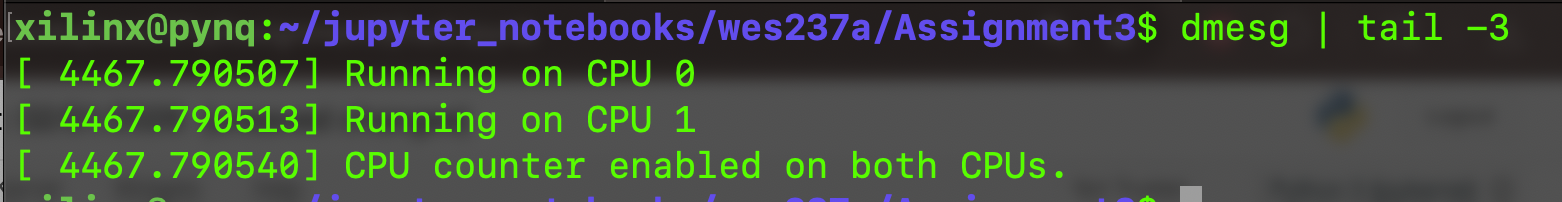 

## Part A3.1: Access PMU from python

In [1]:
! g++ -c -Wall -Werror -fpic ./clock_example/src/main.cpp
! g++ -shared -o libClockExample.so main.o

In [1]:
import ctypes
_libClockExample = ctypes.CDLL('./libClockExample.so')

In [2]:
_libClockExample.init_pmu_wrapper(1,0) # expect a debug msg to print to console

1

In [3]:
_libClockExample.init_pmu_wrapper(1,0,False) # expect no debug msg from the console

1

In [4]:
_libClockExample.get_cyclecount_wrapper()

136736315

In [5]:
for i in range(100):
    print(_libClockExample.get_cyclecount_wrapper())

196157295
196393085
196443230
196488480
196530630
196572888
196613910
196654775
196695997
196738626
196779829
196820314
196860534
196902353
196942952
196983239
197024568
197066105
197107295
197148286
197189596
197232514
197272776
197313215
200003748
200059973
200104172
200150524
200193229
200234702
200276146
200318216
200358837
200400654
200441819
200483856
200525303
200567738
200609070
200651894
200692915
200734032
200774682
200815388
200857052
200897976
200938897
201016729
201061623
201103471
201145141
201186142
201227405
201268203
201309271
201352850
201408119
201451659
201493315
201534798
201576499
201617878
201659431
201700923
201742207
201789837
201831672
201872677
201913013
201953297
201993855
202035719
202077138
202118348
202159452
205585894
205665418
205712903
205755660
205797515
205837982
205878645
205919034
205959992
206001030
208779010
208866860
208924540
208967416
209009137
209051196
209092037
209133067
209173726
209214948
209255643
209296695
209337040
209377390
209417611


### Notes
CPU is roughly 650MHz. For a 32-bit cycle counter ( $2^{32}=4,294,967,296$ ), the overflow timeline without Divider (1:1) is approximately 6.6 seconds before it starts to overflow.

Calculation: $ \frac{2^{32}}{650MHz} \approx 6.607s$. 

With divider enabled (1:64), the counter will overflow in approximately 7 mins.

Calculation: $ \frac{2^{32} \cdot 64}{650MHz} \approx 422.88s = 7.048m$. 

The tricky part was not realizing this math and struggling to understand if the registers were keeping the right time. 

I wanted to see the counters value converted to time so I divided by the cpu clock but quickly overflowed. So I used the `time` python library to sleep during a while loop to see the PMU register values at a very slow speed. When I felt comfortable the time via PMU register was working as expected and lasting only until the theoretical overflow limit I tried to see how I could make it last indefinitely. Of course I was thrown off why the sleep for a second was not insreasing the counter but realizing that the thread is stopped so the cycles are also stopped so it cant accumulate fast enough so thats why it wasnt resuming count, but stopping the thread for 100 $\mu s$ was short enough to still keep track of the time to feel continous enough.

A 32-bit register holds values from $0$ to $4,294,967,295$ ($2^{32} - 1$). MAX_32BIT = 0xFFFFFFFF ($4,294,967,295$). MAX_32BIT + 1 = 0x100000000 ($4,294,967,296$, or $2^{32}$)

- trouble with compiling the shared library gcc -c -Wall -Werror -fpic main.cpp had to use the g++ compiler.

CPU speed was found using `sudo cat /sys/kernel/debug/clk/clk_summary | grep cpu`
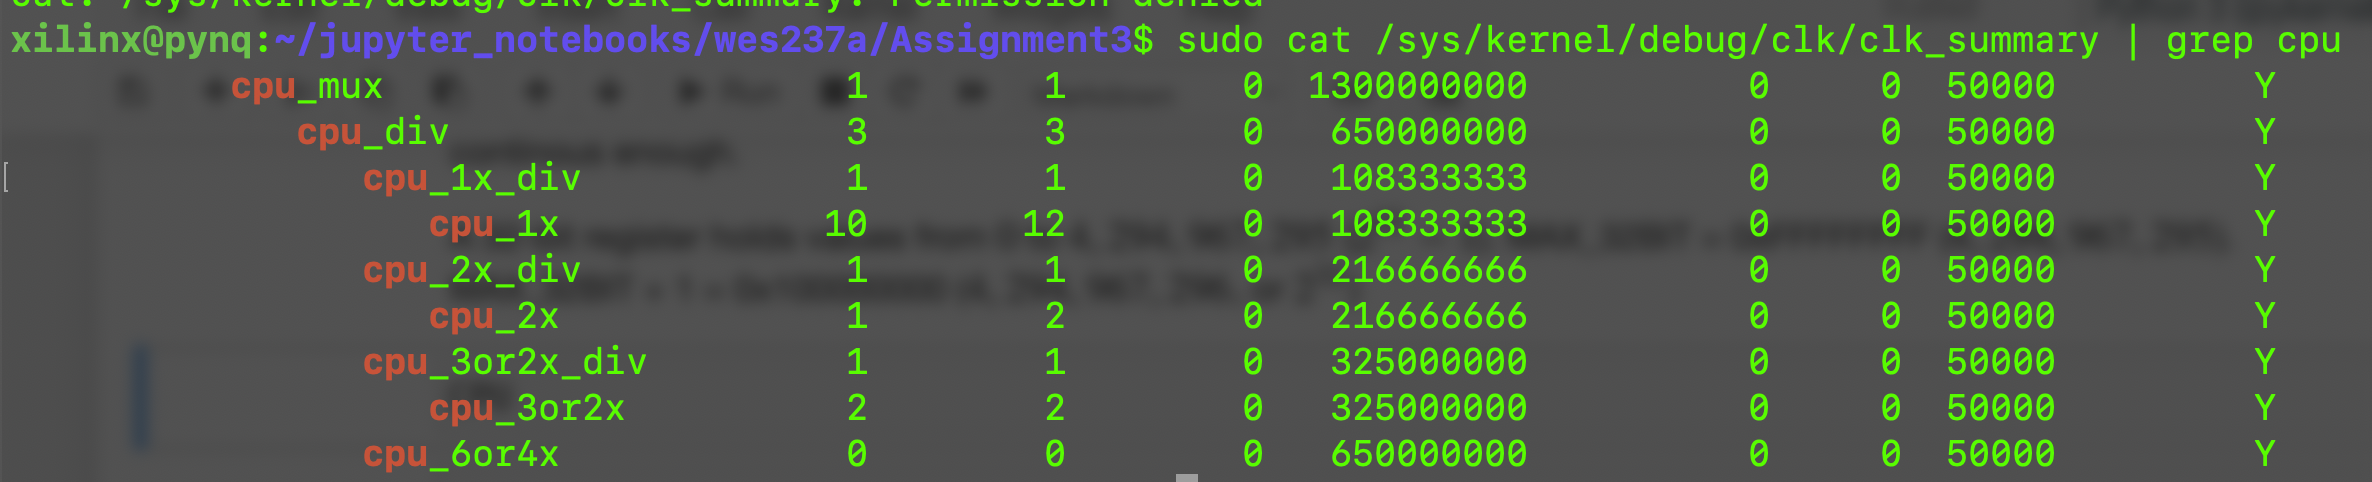

In [6]:
import time

CPU = 650e6
LAPS = 0
LAST_RAW = 0
MAX_32BIT_VAL = 0xFFFFFFFF # 2^32

# init
is_divider_enabled = 0
divider = 64 if is_divider_enabled else 1

_libClockExample.init_pmu_wrapper(1,is_divider_enabled)
# Initialize LAST_RAW so the first loop has a baseline
relative_count = _libClockExample.get_cyclecount_wrapper() & MAX_32BIT_VAL # forces unsigned 32bit val, otherwise python converts to signed integer which looses half its positive values
while True:
    # register value
    current_count = _libClockExample.get_cyclecount_wrapper() & MAX_32BIT_VAL

    # check for overflow
    if current_count < relative_count:
        LAPS += 1
    # update
    relative_count = current_count
    
    # calculate total cycles with lapses
    # max 32 bit val ranges from 0 to 2^32 so add the 1
    total_cycles = ((LAPS * (MAX_32BIT_VAL + 1)) + current_count) * divider
    
    # convert to time
    t = total_cycles / CPU
    
    print(f"\rTime: {t:.3f} sec | Laps: {LAPS}", end="", flush=True)
    
    time.sleep(.001)


reset: 1, divider: 0
Time: 35.981 sec | Laps: 5


KeyboardInterrupt



## Part A3.2: Comparing and Gathering Data

•	Isolate CPU 1 by editing the bootargs (see lab work part 1)

Steps I did to achieve this:

- Connected via `screen /dev/tty.usbserial-1234_tul1 115200`
- Ran `sudo reboot`
- Ran `editenv bootargs` with `'console=ttyPS0,115200 root=/dev/mmcblk0p2 rw earlyprintk rootfstype=ext4 rootwait devtmpfs.mount=1 uio_pdrv_genirq.of_id="generic-uio" clk_ignore_unused isolcpus=1 && bootz 0x03000000 - 0x02A00000'`
- Ran `boot`
- Verified by running `cat /proc/cmdline` which prints the Linux kernel boot arguments that were used when the system started.

Output
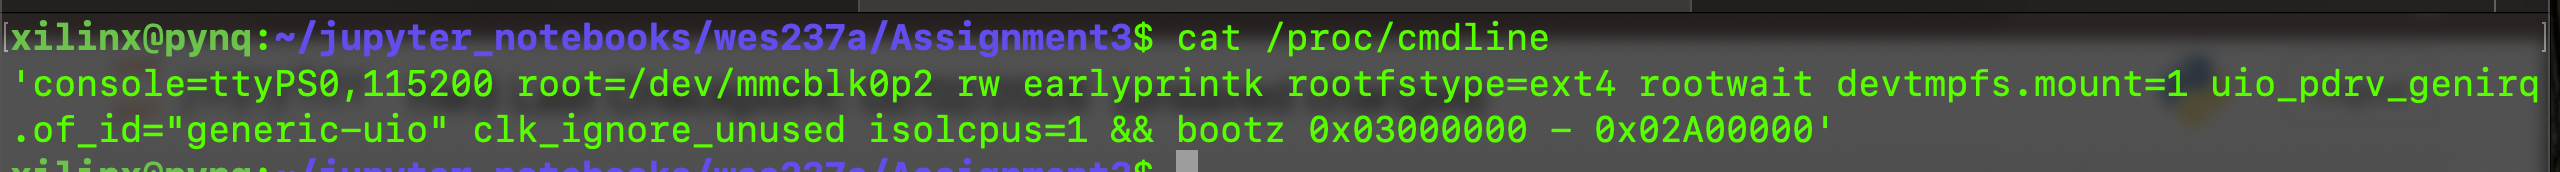

•	Insert the CPUcntr kernel object onto both cpus using the instructions from lab

Done. See [Part A3.0: New kernel_module code](#Part-A3.0:-New-kernel_module-code).

•	Write code to do the following using the recur_fibo function from lab

In [47]:
import time
import matplotlib.pyplot as plt
import math 

def recur_fibo(n):
    if n <= 1:
        return n
    else:
        return(recur_fibo(n-1) + recur_fibo(n-2))

def measure_time(fn,n,debug=True):
    ''' fn - funtion
        n  - args to funtion
        debug - prints to console if enabled
        returns: tuple of (n,t) where 't' is elapsed time in nanoseconds
    '''
    if debug: 
        print('terms: {}'.format(n))
    
    tic = time.perf_counter()    
    fn(n)
    tac = time.perf_counter()
    elapsed_time = tac-tic
    
    if debug:
        print('time spent: {}s'.format(elapsed_time))
        
    return n,elapsed_time

def measure_time_with_PMU(fn, n, is_divider_enabled=1, convert_to_sec=True, debug=True):
    ''' fn - funtion
        n  - args to funtion
        debug - prints to console if enabled
        returns: tuple of (n,t) where 't' is elapsed time in nanoseconds
    '''
    
    CPU_CLCK = 650_000_000 if convert_to_sec else 1 # 650 MHz for each cpu core
    
    if debug: 
        print('terms: {}'.format(n))
        
    _libClockExample.init_pmu_wrapper(1, is_divider_enabled, debug)
    tic = _libClockExample.get_cyclecount_wrapper() & 0xFFFFFFFF
    fn(n)
    tac = _libClockExample.get_cyclecount_wrapper() & 0xFFFFFFFF
    elapsed_cycles= tac-tic
    
    divider = 64 if is_divider_enabled else 1
    t = (elapsed_cycles * divider)/CPU_CLCK
    
    if debug:
        print('time spent: {}s'.format(t))
        
    return n,t

def plot(data, xlabel, ylabel, title, legendtext=None, is_show=True):
    x, y = zip(*data)
    plt.plot(x, y, '-o',markersize=2, label=legendtext)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    
    if is_show:
        plt.legend()
        plt.show()

def plot_runtime(fn, n=30, fnname=None, debug=True, num_trials=1):
    print("Calculating runtimes for "+fnname+ " for {} terms".format(n)+" {} trials".format(num_trials))
    plt.figure(figsize=(10, 6), constrained_layout=True)

    all_trials=[]
    for x in range(num_trials):
        data=[]
        for i in range(1,n,1):
            d=measure_time(fn,i,debug)
            data.append(d)
        plot(data,"n","time (s)","N vs Runtime",legendtext=fnname+" {}".format(x),is_show=False)
        all_trials.append(data)
        
    
    if num_trials > 1:
        x_vals = [pt[0] for pt in all_trials[0]] # could also be 1 to n

        mean_data = []
        std_y = []

        for j in range(len(x_vals)): # j is each nth fib
            ys = [all_trials[k][j][1] for k in range(num_trials)] #loop all trials for each series (n,y) so [y1,y2,...yn]
            mu = sum(ys) / float(num_trials)
            var = sum((y - mu) ** 2 for y in ys) / float(num_trials)
            sigma = math.sqrt(var)

            mean_data.append((x_vals[j], mu))
            std_y.append(sigma)

        plot(mean_data, "n", "time (s)", "N vs Runtime",legendtext=fnname + " mean", is_show=False)
        mean_y = [pt[1] for pt in mean_data]# (n,y) so pt[1]=y
        plt.errorbar(x_vals, mean_y, yerr=std_y, capsize=8, elinewidth=2, capthick=2, fmt='none', ecolor='black')

        overall_mean = sum(mean_y) / len(mean_y)
        overall_std  = sum(std_y) / len(std_y)
        plt.text(0.05, 0.95,
                 f"Mean = {overall_mean:.4f}\nStd = {overall_std:.4f}",
                 transform=plt.gca().transAxes,
                 verticalalignment='top',
                 bbox=dict(facecolor='white',alpha=0.8))
    plt.legend(loc='center left')
    plt.show()

    
def plot_runtime_PMU(fn, n=30, fnname=None, is_divider_enabled=1 ,convert_to_sec=True, debug=True, num_trials=1):
    print("Calculating runtimes for "+fnname+ " for {} terms using PMU counters".format(n)+" {} trials".format(num_trials))
    plt.figure(figsize=(10, 6), constrained_layout=True)
    all_trials=[]
    
    for x in range(num_trials):
        dataPMU=[]
        for i in range(1,n,1):
            dd=measure_time_with_PMU(fn,i,is_divider_enabled=is_divider_enabled,convert_to_sec=convert_to_sec,debug=debug)
            dataPMU.append(dd)
        plot(dataPMU,"n","time (s)" if convert_to_sec else "cpu clock cycle","N vs Runtime from PMU counters",legendtext=fnname+" {}".format(x),is_show=False)
        all_trials.append(dataPMU)
        
    if num_trials > 1:
        x_vals = [pt[0] for pt in all_trials[0]] # could also be 1 to n
        mean_data = []
        std_y = []

        for j in range(len(x_vals)): # j is each nth fib
            ys = [all_trials[k][j][1] for k in range(num_trials)] #loop all trials for each series (n,y) so [y1,y2,...yn]
            mu = sum(ys) / float(num_trials)
            var = sum((y - mu) ** 2 for y in ys) / float(num_trials)
            sigma = math.sqrt(var)
            mean_data.append((x_vals[j], mu))
            std_y.append(sigma)

        plot(mean_data, "n", "time (s)" if convert_to_sec else "cpu clock cycle","N vs Runtime from PMU counters",legendtext=fnname + " mean", is_show=False)
        mean_y = [pt[1] for pt in mean_data]# (n,y) so pt[1]=y
        plt.errorbar(x_vals, mean_y, yerr=std_y, capsize=8, elinewidth=2, capthick=2, fmt='none', ecolor='black')

        overall_mean = sum(mean_y) / len(mean_y)
        overall_std  = sum(std_y) / len(std_y)
        plt.text(0.05, 0.95,
                 f"Mean = {overall_mean:.4f}\nStd = {overall_std:.4f}",
                 transform=plt.gca().transAxes,
                 verticalalignment='top',
                 bbox=dict(facecolor='white',alpha=0.8))
    
    plt.legend(loc='center left')
    plt.show()

Calculating runtimes for fib for 30 terms


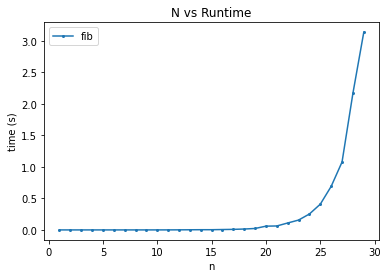

Calculating runtimes for fib for 35 terms using PMU counters


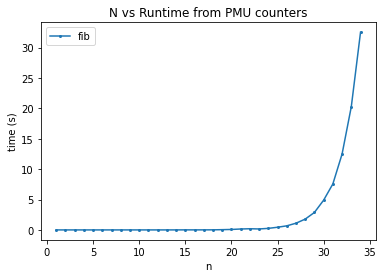

Calculating runtimes for fib for 35 terms using PMU counters


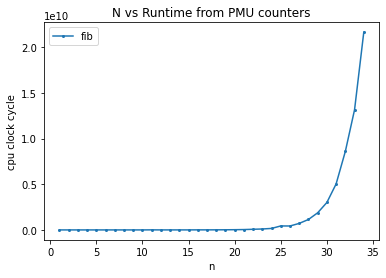

In [17]:
# This plots the runtime of the fibonacci function with jitters from sharing the cpu scheduler with a divider so the theoretical maximum duration is a little over 4mins plenty of time to not overflow
plot_runtime(fn=recur_fibo,n=30,fnname="fib",debug=False)
plot_runtime_PMU(fn=recur_fibo,n=35,fnname="fib",is_divider_enabled=True,debug=False)
plot_runtime_PMU(fn=recur_fibo,n=35,fnname="fib",is_divider_enabled=True,convert_to_sec=False,debug=False)

Calculating runtimes for fib for 30 terms


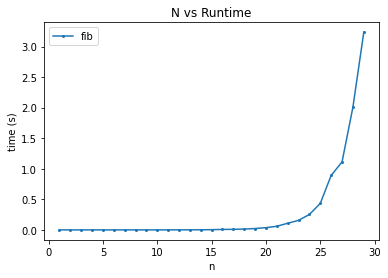

Calculating runtimes for fib for 35 terms using PMU counters


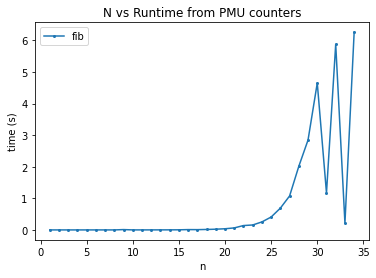

Calculating runtimes for fib for 35 terms using PMU counters


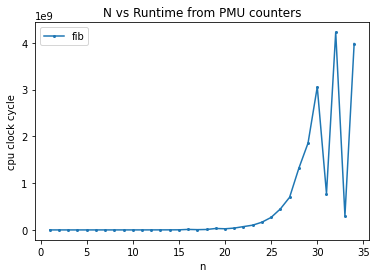

In [16]:
# This plots the runtime of the fibonacci function with jitters from sharing the cpu scheduler with no divider so the theoretical maximum duration is a little over 6secs
plot_runtime(fn=recur_fibo,n=30,fnname="fib",debug=False)
plot_runtime_PMU(fn=recur_fibo,n=35,fnname="fib",is_divider_enabled=False,debug=False)
plot_runtime_PMU(fn=recur_fibo,n=35,fnname="fib",is_divider_enabled=False,convert_to_sec=False,debug=False)

## Calculate the mean runtime
- Vary the number of terms from 1 to 30 as you see fit to compare the different execution times
    - Take multiple trials for each variation (i.e. get three cyclecounts for n=5, then get three cyclecounts for n=10, etc) and average the different tials.
    - The error for each ‘n’ will be the standard deviation from the mean which is the standard deviation of all the trials divided by the square root of the number of trials.
- Plot the average results for varying ‘n’ along with error bars of your measurments.

### Using divider so I can last the longer than the 6 secs 

Calculating runtimes for fib for 30 terms 10 trials


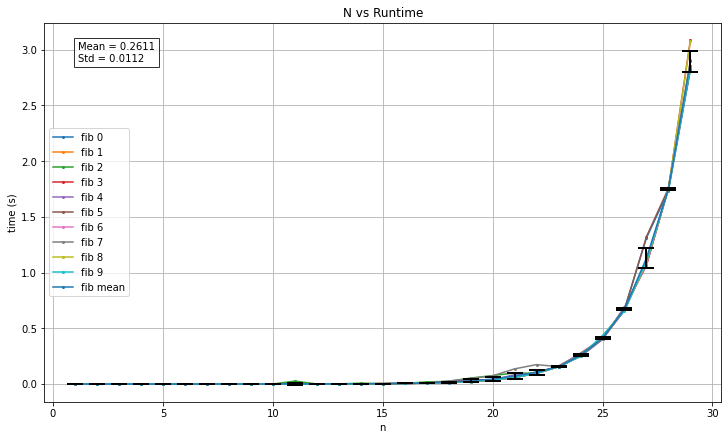

Calculating runtimes for fib for 30 terms using PMU counters 10 trials


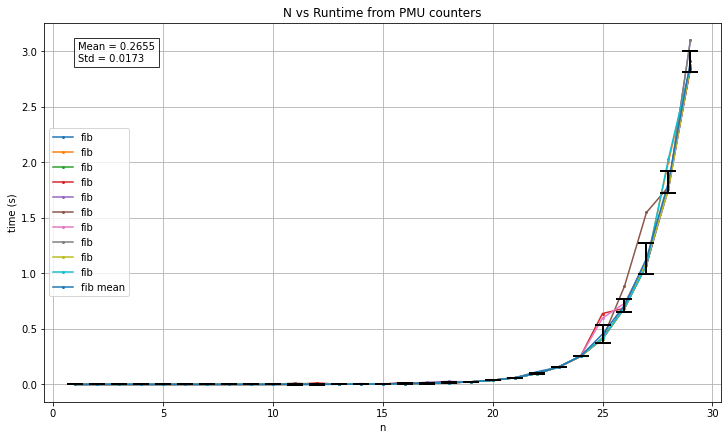

Calculating runtimes for fib for 30 terms using PMU counters 10 trials


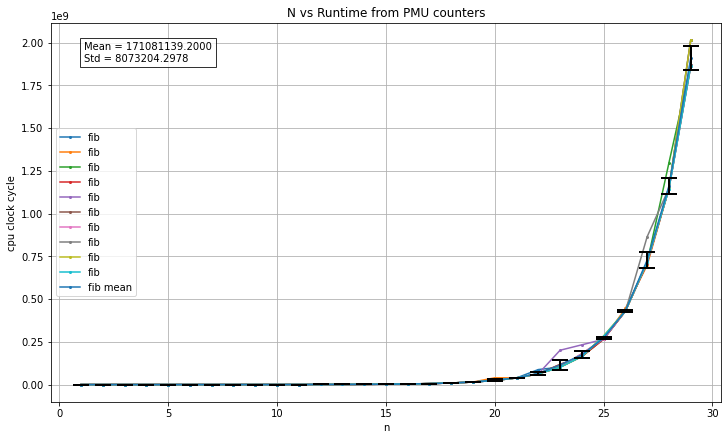

In [44]:
# This plots the runtime of the fibonacci function with jitters from sharing the cpu scheduler with a divider so the theoretical maximum duration is a little over 4mins plenty of time to not overflow
plot_runtime(fn=recur_fibo,n=30,fnname="fib",debug=False, num_trials=10)
plot_runtime_PMU(fn=recur_fibo,n=30,fnname="fib",is_divider_enabled=True,debug=False, num_trials=10)
plot_runtime_PMU(fn=recur_fibo,n=30,fnname="fib",is_divider_enabled=True,convert_to_sec=False,debug=False, num_trials=10)

## Set CPU affinity (run on cpu1)

Help on built-in function sched_setaffinity in module posix:

sched_setaffinity(pid, mask, /)
    Set the CPU affinity of the process identified by pid to mask.
    
    mask should be an iterable of integers identifying CPUs.

Calculating runtimes for fib for 30 terms 1 trials


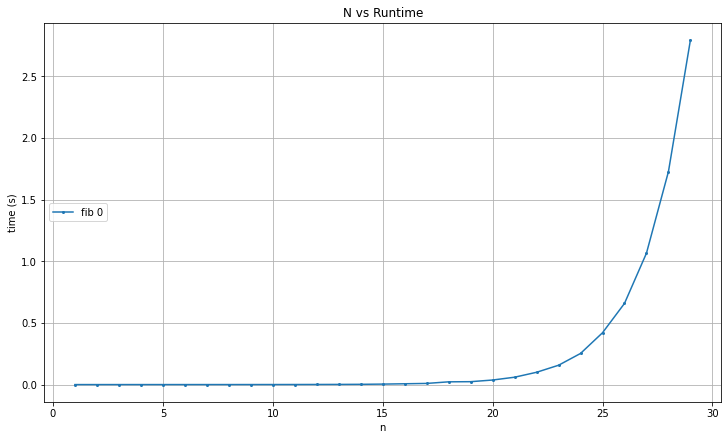

Calculating runtimes for fib for 30 terms using PMU counters 1 trials


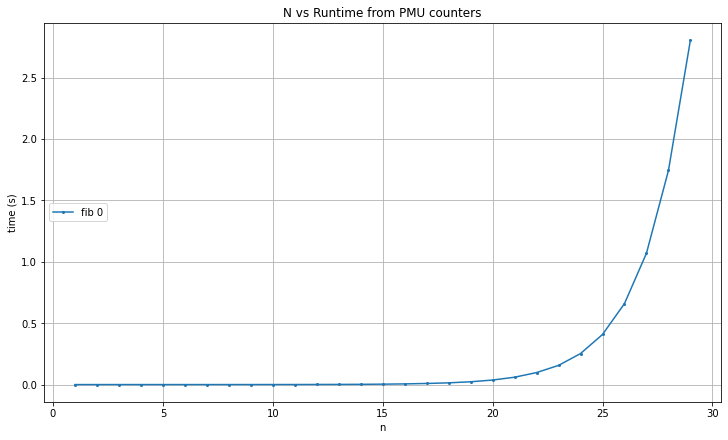

Calculating runtimes for fib for 30 terms using PMU counters 1 trials


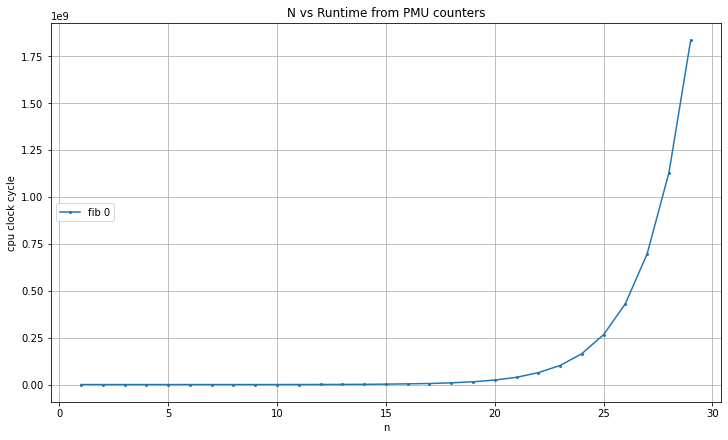

In [48]:
# This plots the runtime of the fibonacci function without jitters from sharing the cpu scheduler
import os

pid = os.getpid()
cpu_core = 1

help(os.sched_setaffinity)
# Set the CPU affinity of the process identified by pid to cpu core 1
os.sched_setaffinity(pid,{cpu_core})

plot_runtime(recur_fibo,30,"fib",debug=False)
plot_runtime_PMU(fn=recur_fibo,n=30,fnname="fib",is_divider_enabled=True,debug=False)
plot_runtime_PMU(fn=recur_fibo,n=30,fnname="fib",is_divider_enabled=True,convert_to_sec=False,debug=False)

## Calculate mean runtime using cpu affinity for cpu core1

Calculating runtimes for fib for 30 terms 10 trials


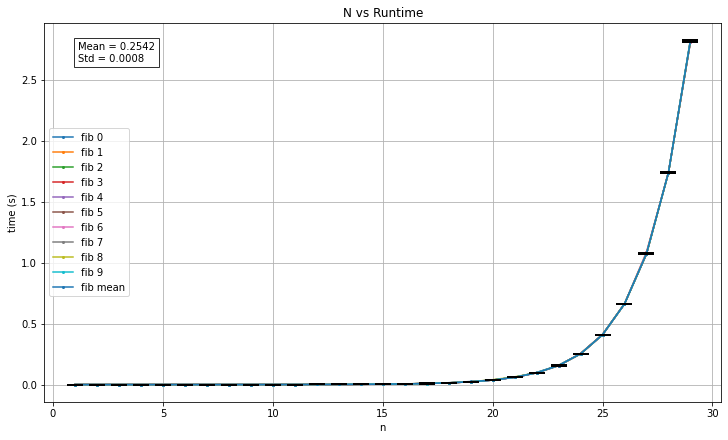

Calculating runtimes for fib for 30 terms using PMU counters 10 trials


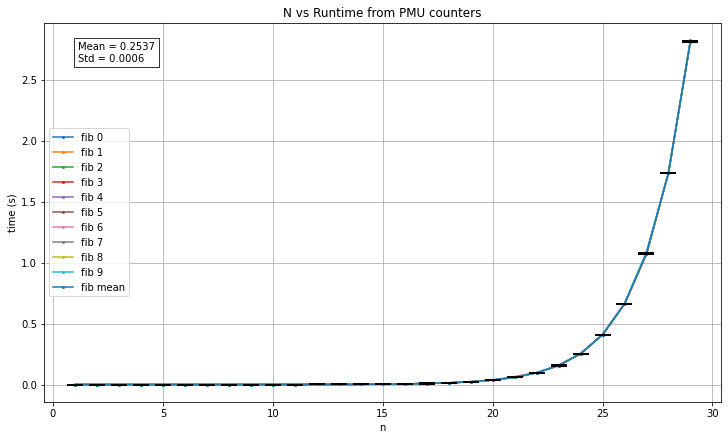

Calculating runtimes for fib for 30 terms using PMU counters 10 trials


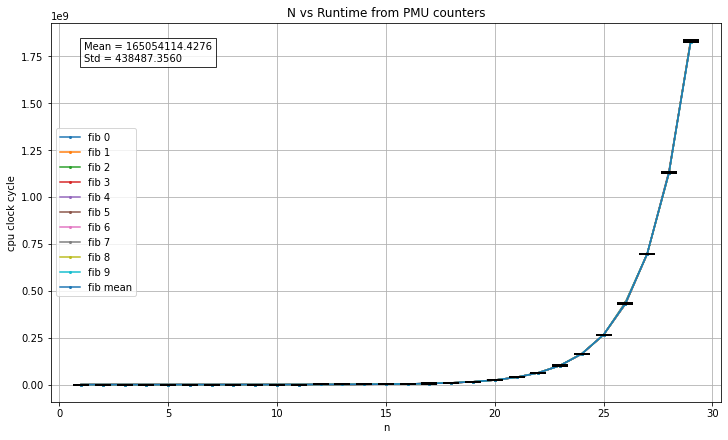

In [49]:
# This plots the runtime of the fibonacci function with jitters from sharing the cpu scheduler with a divider so the theoretical maximum duration is a little over 4mins plenty of time to not overflow
plot_runtime(fn=recur_fibo,n=30,fnname="fib",debug=False, num_trials=10)
plot_runtime_PMU(fn=recur_fibo,n=30,fnname="fib",is_divider_enabled=True,debug=False, num_trials=10)
plot_runtime_PMU(fn=recur_fibo,n=30,fnname="fib",is_divider_enabled=True,convert_to_sec=False,debug=False, num_trials=10)